In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Model



def crear_dataframe(dataset_dir):
    data = {'ruta': [], 'etiqueta': [], 'tipo': []}
    
    for neoplasia in ['ACA', 'SCC', 'benigno']:
        etiqueta = 'maligno' if neoplasia in ['ACA', 'SCC'] else 'benigno'
        neoplasia_dir = os.path.join(dataset_dir, neoplasia)
        
        for filename in os.listdir(neoplasia_dir):
            parts = filename.split('_')
            if len(parts) > 2:
                tipo_cancer = parts[1]  # Asumiendo que 'colon', 'lung', etc., están en esta parte del nombre
                
                ruta_completa = os.path.join(neoplasia_dir, filename)
                data['ruta'].append(ruta_completa)
                data['etiqueta'].append(etiqueta)
                data['tipo'].append(tipo_cancer)
    
    return pd.DataFrame(data)

def crear_generadores(df, target_size=(256, 256), batch_size=20):
    # Crear el ImageDataGenerator para reescalado
    datagen = ImageDataGenerator(rescale=1./255)

    # Dividir el DataFrame para entrenamiento, validación y prueba
    train_df, test_val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['etiqueta'])
    val_df, test_df = train_test_split(test_val_df, test_size=(1/3), random_state=42, stratify=test_val_df['etiqueta'])

    # Crear los generadores
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='ruta',
        y_col='etiqueta',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # Asumiendo clasificación binaria
        shuffle=True
    )
    
    validation_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='ruta',
        y_col='etiqueta',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    
    test_generator = datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='ruta',
        y_col='etiqueta',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True  
    )
    
    return train_generator, validation_generator, test_generator

# Uso de las funciones
dataset_dir = r"C:/Users/Matias/Desktop/Tesis/Dataset_Neoplasias"
df = crear_dataframe(dataset_dir)
train_gen, val_gen, test_gen = crear_generadores(df)



Found 31660 validated image filenames belonging to 2 classes.


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 864 invalid image filename(s) in x_col="ruta". These filename(s) will be ignored.
  warnings.warn(


Found 9058 validated image filenames belonging to 2 classes.
Found 4522 validated image filenames belonging to 2 classes.


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 235 invalid image filename(s) in x_col="ruta". These filename(s) will be ignored.
  warnings.warn(
c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 125 invalid image filename(s) in x_col="ruta". These filename(s) will be ignored.
  warnings.warn(


In [5]:
import torch
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import pandas as pd
import os
# Función para crear un DataFrame desde el directorio del dataset
def crear_dataframe_multiclase(dataset_dir, filtro_cancer = 'all'):
    data = {'ruta': [], 'etiqueta': [], 'tipo_cancer': []}
    for categoria in os.listdir(dataset_dir):  # Asume que cada subcarpeta es una categoría
        categoria_dir = os.path.join(dataset_dir, categoria)
        for filename in os.listdir(categoria_dir):
            parts = filename.split('_')
            
            # Determinar el tipo de cáncer y la etiqueta basado en el nombre del archivo
            if len(parts) > 2 and parts[0] == 'oral':
                tipo_cancer = parts[0]  # 'oral'
                etiqueta = parts[1]     # 'benigno' o 'maligno'
            elif len(parts) == 3:
                tipo_cancer, etiqueta, _ = parts  # Formato antiguo
            else:
                print(f"Archivo {filename} ignorado por tener un formato incorrecto.")
                continue

            ruta_completa = os.path.join(categoria_dir, filename)
            data['ruta'].append(ruta_completa)
            data['etiqueta'].append(etiqueta)
            data['tipo_cancer'].append(tipo_cancer)
    if filtro_cancer != 'all':
        data = data[data['tipo_cancer'] == filtro_cancer]
        
    return pd.DataFrame(data)


df = crear_dataframe_multiclase(dataset_dir = r"C:/Users/Matias/Desktop/Tesis/Dataset_Neoplasias")
a = df[df['etiqueta']=='benigno']

,ruta,etiqueta,tipo_cancer
14000,C:/Users/Matias/Desktop/Tesis/Dataset_Neoplasi...,benigno,colon
14001,C:/Users/Matias/Desktop/Tesis/Dataset_Neoplasi...,benigno,colon
14002,C:/Users/Matias/Desktop/Tesis/Dataset_Neoplasi...,benigno,colon
14003,C:/Users/Matias/Desktop/Tesis/Dataset_Neoplasi...,benigno,colon
14004,C:/Users/Matias/Desktop/Tesis/Dataset_Neoplasi...,benigno,colon
...,...,...,...
31185,C:/Users/Matias/Desktop/Tesis/Dataset_Neoplasi...,benigno,oral
31186,C:/Users/Matias/Desktop/Tesis/Dataset_Neoplasi...,benigno,oral
31187,C:/Users/Matias/Desktop/Tesis/Dataset_Neoplasi...,benigno,oral
31188,C:/Users/Matias/Desktop/Tesis/Dataset_Neoplasi...,benigno,oral


In [1]:
import tensorflow as tf

print("Dispositivos disponibles:", tf.config.list_physical_devices())

Dispositivos disponibles: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Matriz de confusion

In [2]:
# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8,8))
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, decimals=3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Modelos Generales

## Modelo propio

In [3]:
def entrenar_modelo_propio(train_gen, val_gen):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'FalsePositives', 'FalseNegatives'])

    history = model.fit(train_gen,
                        steps_per_epoch=200,  # Ajustar según el tamaño de tu conjunto de datos
                        epochs=10,
                        validation_data=val_gen,
                        validation_steps=50)  # Ajustar según el tamaño de tu conjunto de datos

    return model, history

# Ejecutar la función de entrenamiento
model, history = entrenar_modelo_propio(train_gen, val_gen)


Epoch 1/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 366ms/step - FalseNegatives: 121.6337 - FalsePositives: 152.5148 - accuracy: 0.7024 - loss: 0.5891 - val_FalseNegatives: 29.0000 - val_FalsePositives: 153.0000 - val_accuracy: 0.8180 - val_loss: 0.4430
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 351ms/step - FalseNegatives: 73.9901 - FalsePositives: 109.3762 - accuracy: 0.8148 - loss: 0.4435 - val_FalseNegatives: 60.0000 - val_FalsePositives: 88.0000 - val_accuracy: 0.8520 - val_loss: 0.3911
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 353ms/step - FalseNegatives: 64.6733 - FalsePositives: 114.3069 - accuracy: 0.8202 - loss: 0.4122 - val_FalseNegatives: 7.0000 - val_FalsePositives: 183.0000 - val_accuracy: 0.8100 - val_loss: 0.4081
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 359ms/step - FalseNegatives: 53.6139 - FalsePositives: 118.3564 - accuracy: 0.8339 - loss: 0.3979 - val_FalseNegatives: 81.0000 - val_FalsePositives: 73.0000 - val_accuracy: 0.8460 - val_loss: 0.3918
Epoch 5/10
100/100 ━━━━━━━━━━━━━━

c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


227/227 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - FalseNegatives: 114.4649 - FalsePositives: 211.7763 - accuracy: 0.8553 - loss: 0.3644
Test Loss: 0.3644004762172699, Test Accuracy: 226.0, False Positives: 413.0, False Negatives: 0.8586908578872681
227/227 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step
Confusion matrix, without normalization


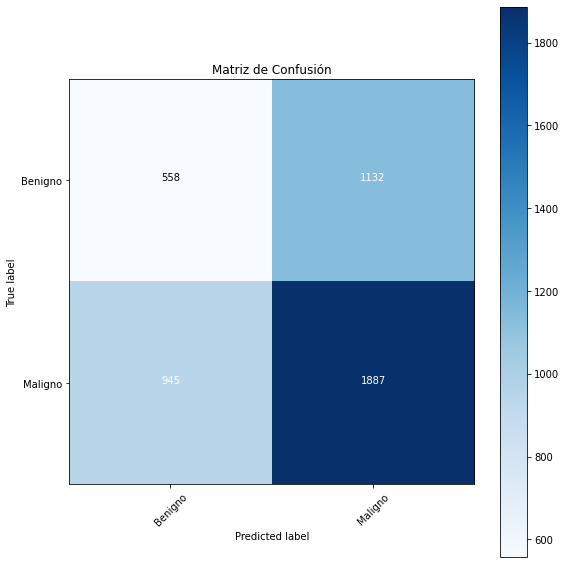

              precision    recall  f1-score   support

     Benigno       0.37      0.33      0.35      1690
     Maligno       0.63      0.67      0.65      2832

    accuracy                           0.54      4522
   macro avg       0.50      0.50      0.50      4522
weighted avg       0.53      0.54      0.53      4522



In [4]:
# Guardar el modelo
model.save('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/modelo_general_propio.h5')

# Guardar el historial de entrenamiento
with open('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/historial_general_propio.pickle', 'wb') as f:
    pickle.dump(history.history, f)


# Evaluar el modelo con el conjunto de prueba
test_loss, test_acc, test_fp, test_fn = model.evaluate(test_gen)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}, False Positives: {test_fp}, False Negatives: {test_fn}")


# Asumiendo que el modelo ya está cargado, si no es así, descomenta la siguiente línea
# model = load_model('modelo_complejo.h5')

# Obtener las etiquetas reales y hacer predicciones
test_labels = test_gen.classes
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = (predictions > 0.5).astype(int).flatten()


# Calcular la matriz de confusión
cm = confusion_matrix(test_labels, predicted_classes)

# Visualizar la matriz de confusión
class_names = ['Benigno', 'Maligno']  # Asumiendo que 0 = Benigno y 1 = Maligno
plot_confusion_matrix(cm, classes=class_names, title='Matriz de Confusión')

# Mostrar reporte de clasificación
print(classification_report(test_labels, predicted_classes, target_names=class_names))

## Modelos preentrenados

### ResNet

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 103s 501ms/step - FalseNegatives: 285.9652 - FalsePositives: 577.1443 - accuracy: 0.5569 - loss: 0.7481 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 415.0000 - val_accuracy: 0.5850 - val_loss: 0.6827
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 106s 533ms/step - FalseNegatives: 117.2239 - FalsePositives: 686.5870 - accuracy: 0.6028 - loss: 0.6784 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 370.0000 - val_accuracy: 0.6300 - val_loss: 0.6540
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 104s 523ms/step - FalseNegatives: 74.5970 - FalsePositives: 683.9801 - accuracy: 0.6207 - loss: 0.6642 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 368.0000 - val_accuracy: 0.6320 - val_loss: 0.6475
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 107s 533ms/step - FalseNegatives: 6.1542 - FalsePositives: 711.0249 - accuracy: 0.6405 - loss: 0.6550 - val_FalseNegatives: 1.0000 - val_FalsePositives: 354.000

c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 89s 444ms/step - FalseNegatives: 20.0900 - FalsePositives: 707.1350 - accuracy: 0.6358 - loss: 0.6461 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 379.0000 - val_accuracy: 0.6210 - val_loss: 0.6499
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 94s 469ms/step - FalseNegatives: 26.8458 - FalsePositives: 741.1990 - accuracy: 0.6239 - loss: 0.6449 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 375.0000 - val_accuracy: 0.6250 - val_loss: 0.6493
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 381ms/step - FalseNegatives: 16.8756 - FalsePositives: 730.5920 - accuracy: 0.6340 - loss: 0.6447 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 18.0000 - val_accuracy: 0.6897 - val_loss: 0.4664


227/227 ━━━━━━━━━━━━━━━━━━━━ 87s 379ms/step
Confusion matrix, without normalization


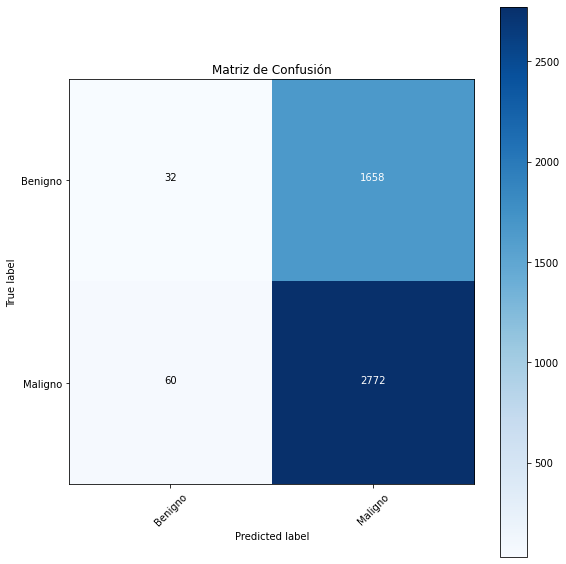

              precision    recall  f1-score   support

     Benigno       0.35      0.02      0.04      1690
     Maligno       0.63      0.98      0.76      2832

    accuracy                           0.62      4522
   macro avg       0.49      0.50      0.40      4522
weighted avg       0.52      0.62      0.49      4522



In [5]:
def entrenar_modelo_ResNet50(train_gen, val_gen):
    # Cargar ResNet50 preentrenado como base, sin incluir las capas superiores
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # Construir la arquitectura del modelo añadiendo nuevas capas
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Reducción de dimensiones
    x = Dense(256, activation='relu')(x)  # Capa densa adicional similar a tu modelo
    x = Dropout(0.5)(x)  # Dropout para regularización
    predictions = Dense(1, activation='sigmoid')(x)  # Capa de salida para clasificación binaria

    # Formar el modelo completo especificando entradas y salidas
    model = Model(inputs=base_model.input, outputs=predictions)

    # Congelar las capas del modelo base para no ajustar sus pesos durante el entrenamiento
    for layer in base_model.layers:
        layer.trainable = False

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'FalsePositives', 'FalseNegatives'])

    # Entrenar el modelo
    history = model.fit(train_gen,
                        steps_per_epoch=200,  # Ajusta este valor según el tamaño de tu conjunto de datos
                        epochs=10,  # Número de épocas de entrenamiento
                        validation_data=val_gen,
                        validation_steps=50)  # Ajusta este valor según el tamaño de tu conjunto de validación

    return model, history

# Asegúrate de que 'train_gen' y 'val_gen' están correctamente inicializados
model, history = entrenar_modelo_ResNet50(train_gen, val_gen)

# Guardar el modelo
model.save('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/resnet50_modelo.h5')

# Guardar el historial de entrenamiento
with open('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/resnet50_historial.pickle', 'wb') as f:
    pickle.dump(history.history, f)

# Suponiendo que test_gen es tu generador de prueba
test_labels = test_gen.classes
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = (predictions > 0.5).astype(int).flatten()
# Calcular la matriz de confusión
cm = confusion_matrix(test_labels, predicted_classes)
class_names = ['Benigno', 'Maligno']  # Asumiendo que 0 = Benigno y 1 = Maligno

# Visualizar la matriz de confusión
plot_confusion_matrix(cm, classes=class_names, title='Matriz de Confusión')
# Mostrar el reporte de clasificación
print(classification_report(test_labels, predicted_classes, target_names=class_names))




### VGG16

In [6]:
def entrenar_modelo_VGG16(train_gen, val_gen):
    # Cargar VGG16 preentrenado como base, sin incluir las capas superiores
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # Añadir nuevas capas personalizadas
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Agregar Dropout para ayudar a prevenir el sobreajuste
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Definir el modelo completo
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Congelar las capas del modelo base
    for layer in base_model.layers:
        layer.trainable = False

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'FalsePositives', 'FalseNegatives'])

    # Entrenar el modelo
    history = model.fit(train_gen,
                        epochs=10,
                        steps_per_epoch=200,  # Ajustar según el tamaño del conjunto de datos
                        validation_data=val_gen,
                        validation_steps=50)  # Ajustar según el tamaño del conjunto de validación

    # Guardar el modelo y el historial
    model.save('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/vgg16_modelo.h5')
    with open('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/vgg16_historial.pickle', 'wb') as f:
        pickle.dump(history.history, f)
    
    return model, history


# Asumiendo que 'train_gen' y 'val_gen' están correctamente configurados
model, history = entrenar_modelo_VGG16(train_gen, val_gen)
# Suponiendo que test_gen es tu generador de prueba
test_labels = test_gen.classes
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = (predictions > 0.5).astype(int).flatten()
# Mostrar el reporte de clasificación
print(classification_report(test_labels, predicted_classes, target_names=class_names))



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - FalseNegatives: 103.0199 - FalsePositives: 306.0348 - accuracy: 0.7704 - loss: 0.4974 - val_FalseNegatives: 13.0000 - val_FalsePositives: 67.0000 - val_accuracy: 0.9200 - val_loss: 0.2794
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - FalseNegatives: 84.8408 - FalsePositives: 166.2935 - accuracy: 0.8755 - loss: 0.3192 - val_FalseNegatives: 26.0000 - val_FalsePositives: 65.0000 - val_accuracy: 0.9090 - val_loss: 0.2508
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - FalseNegatives: 67.6070 - FalsePositives: 126.0696 - accuracy: 0.9027 - loss: 0.2631 - val_FalseNegatives: 17.0000 - val_FalsePositives: 69.0000 - val_accuracy: 0.9140 - val_loss: 0.2361
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - FalseNegatives: 51.6318 - FalsePositives: 120.5373 - accuracy: 0.9161 - loss: 0.2264 - val_FalseNegatives: 35.0000 - val_FalsePositives: 53.0000 - val_accuracy: 0.9120

c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - FalseNegatives: 53.7200 - FalsePositives: 120.1200 - accuracy: 0.9068 - loss: 0.2268 - val_FalseNegatives: 14.0000 - val_FalsePositives: 63.0000 - val_accuracy: 0.9230 - val_loss: 0.1948
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - FalseNegatives: 46.7214 - FalsePositives: 115.1642 - accuracy: 0.9195 - loss: 0.2052 - val_FalseNegatives: 26.0000 - val_FalsePositives: 57.0000 - val_accuracy: 0.9170 - val_loss: 0.1852
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 183s 916ms/step - FalseNegatives: 42.1940 - FalsePositives: 113.7811 - accuracy: 0.9214 - loss: 0.1941 - val_FalseNegatives: 3.0000 - val_FalsePositives: 2.0000 - val_accuracy: 0.9138 - val_loss: 0.1850


227/227 ━━━━━━━━━━━━━━━━━━━━ 205s 903ms/step
              precision    recall  f1-score   support

     Benigno       0.38      0.38      0.38      1690
     Maligno       0.63      0.63      0.63      2832

    accuracy                           0.53      4522
   macro avg       0.50      0.50      0.50      4522
weighted avg       0.53      0.53      0.53      4522



# Ahora aplicamos un modelo por tipo de neoplasia, 3 Clases (ACA, SCC y Benigno)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd


def crear_generadores(df, target_size=(256, 256), batch_size=32, test_size=0.2, val_size=0.25):
    # Primero, dividimos los datos en conjuntos de entrenamiento+validación y prueba
    train_val_df, test_df = train_test_split(df, test_size=test_size, shuffle=True)
    # Luego, dividimos el conjunto de entrenamiento+validación en entrenamiento y validación
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, shuffle=True)  # val_size aquí es proporcional al tamaño de train_val_df

    datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=None,  # todas las rutas están completas en el DataFrame
        x_col='ruta',
        y_col='tipo',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=None,  # todas las rutas están completas en el DataFrame
        x_col='ruta',
        y_col='tipo',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    test_generator = datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=None,  # todas las rutas están completas en el DataFrame
        x_col='ruta',
        y_col='tipo',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Generalmente no mezclamos el conjunto de prueba para evaluar en el mismo orden
    )

    return train_generator, validation_generator, test_generator

# Suponiendo que df ya está cargado y listo
train_gen, val_gen, test_gen = crear_generadores(df)


Found 27156 validated image filenames belonging to 3 classes.


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 722 invalid image filename(s) in x_col="ruta". These filename(s) will be ignored.
  warnings.warn(


Found 9034 validated image filenames belonging to 3 classes.


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 259 invalid image filename(s) in x_col="ruta". These filename(s) will be ignored.
  warnings.warn(


Found 9050 validated image filenames belonging to 3 classes.


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 243 invalid image filename(s) in x_col="ruta". These filename(s) will be ignored.
  warnings.warn(


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 140s 697ms/step - accuracy: 0.5162 - loss: 1.5860 - val_accuracy: 0.6667 - val_loss: 0.7352
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 138s 693ms/step - accuracy: 0.7104 - loss: 0.6680 - val_accuracy: 0.7606 - val_loss: 0.6222
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 140s 700ms/step - accuracy: 0.7539 - loss: 0.6089 - val_accuracy: 0.7980 - val_loss: 0.5124
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 140s 701ms/step - accuracy: 0.7937 - loss: 0.5195 - val_accuracy: 0.8067 - val_loss: 0.4850
Epoch 5/10
 49/200 ━━━━━━━━━━━━━━━━━━━━ 1:18 522ms/step - accuracy: 0.8136 - loss: 0.4644

c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 58s 286ms/step - accuracy: 0.8156 - loss: 0.4630 - val_accuracy: 0.8159 - val_loss: 0.4710
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 138s 686ms/step - accuracy: 0.8289 - loss: 0.4473 - val_accuracy: 0.8248 - val_loss: 0.4416
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 138s 693ms/step - accuracy: 0.8283 - loss: 0.4204 - val_accuracy: 0.8226 - val_loss: 0.4390
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 137s 684ms/step - accuracy: 0.8467 - loss: 0.3851 - val_accuracy: 0.7475 - val_loss: 0.5729
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 136s 683ms/step - accuracy: 0.8395 - loss: 0.3891 - val_accuracy: 0.8363 - val_loss: 0.4009
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 286ms/step - accuracy: 0.8453 - loss: 0.3635 - val_accuracy: 0.8130 - val_loss: 0.4438


283/283 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step
Confusion matrix, without normalization


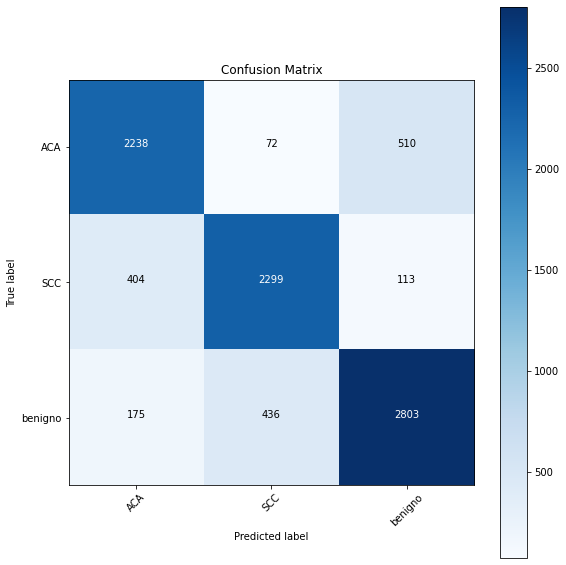

              precision    recall  f1-score   support

         ACA       0.79      0.79      0.79      2820
         SCC       0.82      0.82      0.82      2816
     benigno       0.82      0.82      0.82      3414

    accuracy                           0.81      9050
   macro avg       0.81      0.81      0.81      9050
weighted avg       0.81      0.81      0.81      9050



In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def entrenar_modelo_propio_multiclase(train_gen, val_gen):
    # Aquí usamos 'class_indices' para obtener el número de clases
    num_classes = len(train_gen.class_indices)
    
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')  # Cambio para clasificación multiclase
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',  # Cambio a categorical_crossentropy
                  metrics=['accuracy'])
    
    history = model.fit(train_gen, 
                        validation_data=val_gen,
                        steps_per_epoch=200, 
                        epochs=10)  # Número de épocas ajustable
    #Guardamos el modelo
    model.save('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/modelo_general_propio_multiclase.h5')
    with open('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/historial_general_propio_multiclase.pickle', 'wb') as f:
        pickle.dump(history.history, f)

    return model, history

# Asumiendo que 'train_gen' y 'val_gen' están correctamente configurados
model, history = entrenar_modelo_propio_multiclase(train_gen, val_gen)
# Evaluar el modelo
test_labels = test_gen.classes
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = np.argmax(predictions, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(test_labels, predicted_classes)
class_names = list(val_gen.class_indices.keys())  # nombres de clases

# Función para graficar la matriz de confusión
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

# Reporte de clasificación
print(classification_report(test_labels, predicted_classes, target_names=class_names))

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 768ms/step - accuracy: 0.3638 - loss: 1.2578 - val_accuracy: 0.4100 - val_loss: 1.0804
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 762ms/step - accuracy: 0.3924 - loss: 1.0919 - val_accuracy: 0.4737 - val_loss: 1.0555
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 765ms/step - accuracy: 0.4353 - loss: 1.0709 - val_accuracy: 0.4744 - val_loss: 1.0614
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 765ms/step - accuracy: 0.4590 - loss: 1.0564 - val_accuracy: 0.4700 - val_loss: 1.0590
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 60s 300ms/step - accuracy: 0.4798 - loss: 1.0331 - val_accuracy: 0.4863 - val_loss: 1.0497
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 709ms/step - accuracy: 0.4613 - loss: 1.0530 - val_accuracy: 0.4652 - val_loss: 1.0182
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 761ms/step - accuracy: 0.4563 - loss: 1.0539 - val_accuracy: 0.4725 - val_loss: 1.0485
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 765ms/step - accuracy: 0.4495 - 

283/283 ━━━━━━━━━━━━━━━━━━━━ 174s 613ms/step
Confusion matrix, without normalization


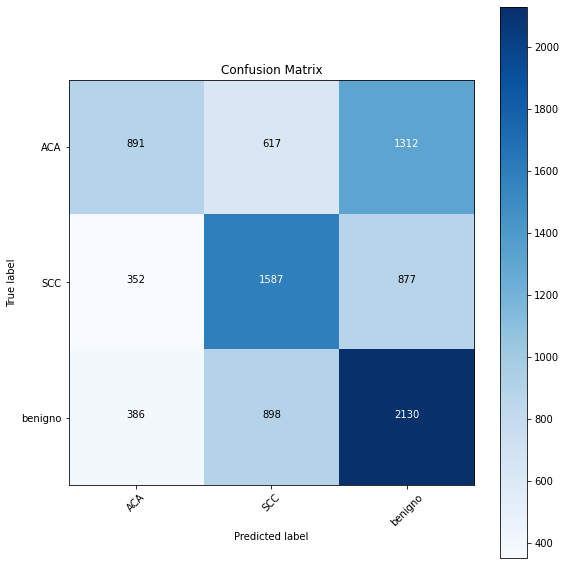

              precision    recall  f1-score   support

         ACA       0.55      0.32      0.40      2820
         SCC       0.51      0.56      0.54      2816
     benigno       0.49      0.62      0.55      3414

    accuracy                           0.51      9050
   macro avg       0.52      0.50      0.50      9050
weighted avg       0.52      0.51      0.50      9050



In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def entrenar_modelo_ResNet50_multiclase(train_gen, val_gen):
    num_classes = len(train_gen.class_indices)  

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)  # Cambio para clasificación multiclase

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',  # Cambio a categorical_crossentropy
                  metrics=['accuracy'])

    history = model.fit(train_gen,
                        steps_per_epoch=200,
                        epochs=10,
                        validation_data=val_gen,
                        validation_steps=50)
    # Guardar el modelo y el historial
    model.save('C:/Users/Matias/Desktop/Tesis/Encoder_models/neoplasias_type_models/resnet50_multi_model.h5')
    with open('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/neoplasias_type_models/resnet50_multi_historial.pickle', 'wb') as f:
        pickle.dump(history.history, f)

    return model, history


# Asumiendo que 'train_gen' y 'val_gen' están correctamente configurados
model, history = entrenar_modelo_ResNet50_multiclase(train_gen, val_gen)
# Evaluar el modelo
test_labels = test_gen.classes
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = np.argmax(predictions, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(test_labels, predicted_classes)
class_names = list(val_gen.class_indices.keys())  # nombres de clases

# Función para graficar la matriz de confusión
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

# Reporte de clasificación
print(classification_report(test_labels, predicted_classes, target_names=class_names))

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 684s 3s/step - accuracy: 0.6575 - loss: 0.7691 - val_accuracy: 0.8404 - val_loss: 0.4707
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step - accuracy: 0.8434 - loss: 0.4283 - val_accuracy: 0.8653 - val_loss: 0.3520
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 681s 3s/step - accuracy: 0.8640 - loss: 0.3456 - val_accuracy: 0.8848 - val_loss: 0.3032
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 684s 3s/step - accuracy: 0.8773 - loss: 0.3051 - val_accuracy: 0.8896 - val_loss: 0.2827
Epoch 5/10
 49/200 ━━━━━━━━━━━━━━━━━━━━ 3:35 1s/step - accuracy: 0.8978 - loss: 0.2700

c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - accuracy: 0.8926 - loss: 0.2675 - val_accuracy: 0.8890 - val_loss: 0.2675
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 687s 3s/step - accuracy: 0.9009 - loss: 0.2494 - val_accuracy: 0.8987 - val_loss: 0.2487
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 685s 3s/step - accuracy: 0.8960 - loss: 0.2497 - val_accuracy: 0.8988 - val_loss: 0.2593
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 685s 3s/step - accuracy: 0.9047 - loss: 0.2390 - val_accuracy: 0.9045 - val_loss: 0.2408
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 684s 3s/step - accuracy: 0.9050 - loss: 0.2250 - val_accuracy: 0.9044 - val_loss: 0.2396
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 469s 2s/step - accuracy: 0.9027 - loss: 0.2238 - val_accuracy: 0.8950 - val_loss: 0.2490


283/283 ━━━━━━━━━━━━━━━━━━━━ 403s 1s/step
Confusion matrix, without normalization


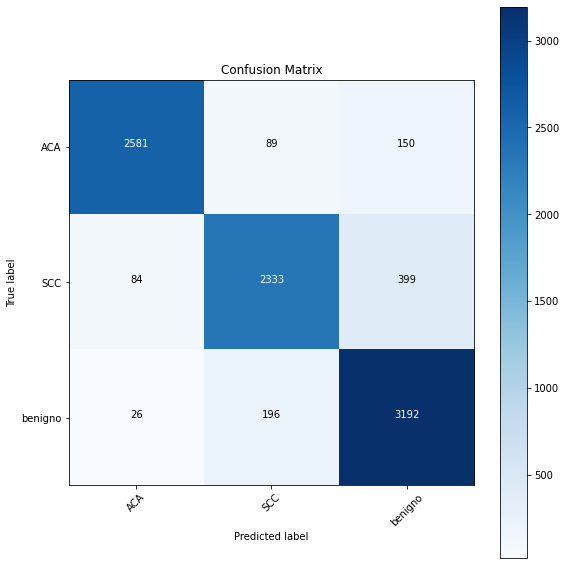

              precision    recall  f1-score   support

         ACA       0.96      0.92      0.94      2820
         SCC       0.89      0.83      0.86      2816
     benigno       0.85      0.93      0.89      3414

    accuracy                           0.90      9050
   macro avg       0.90      0.89      0.90      9050
weighted avg       0.90      0.90      0.90      9050



In [12]:


def entrenar_modelo_VGG16_multiclase(train_gen, val_gen):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(len(train_gen.class_indices), activation='softmax')(x)  # Usar softmax para múltiples clases

    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',  # Cambiar a categorical_crossentropy
                  metrics=['accuracy'])

    history = model.fit(train_gen,
                         steps_per_epoch=200,
                        epochs=10,
                        validation_data=val_gen)
    
    # Guardar el modelo y el historial
    model.save('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/neoplasias_type_models/vgg16_multi_model.h5')
    with open('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/neoplasias_type_models/vgg16_multi_historial.pickle', 'wb') as f:
        pickle.dump(history.history, f)

    return model, history

# Asumiendo que 'train_gen' y 'val_gen' están correctamente configurados
model, history = entrenar_modelo_VGG16_multiclase(train_gen, val_gen)
# Evaluar el modelo
test_labels = test_gen.classes
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = np.argmax(predictions, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(test_labels, predicted_classes)
class_names = list(val_gen.class_indices.keys())  # nombres de clases

# Función para graficar la matriz de confusión
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

# Reporte de clasificación
print(classification_report(test_labels, predicted_classes, target_names=class_names))



# Ahora aplicamos Auto - Encoder, teniendo en cuenta que son varios modelos, uno por cada tipo de cancer

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,067 (203.39 KB)

 Trainable params: 52,067 (203.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 774ms/step - accuracy: 0.6773 - loss: 0.0302
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 159us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 762ms/step - accuracy: 0.7879 - loss: 0.0103
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 763ms/step - accuracy: 0.7996 - loss: 0.0090
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 762ms/step - accuracy: 0.8107 - loss: 0.0086
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 763ms/step - accuracy: 0.8191 - loss: 0.0081
Epoch 10/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 30us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 760ms/step - acc

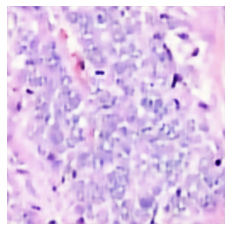

In [18]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

np.random.seed(42)

img_size = 256
folder_path = "C:/Users/Matias/Desktop/Tesis/Dataset_Neoplasias/ACA"
max_images = 10000

# Cargar una cantidad limitada de imágenes en la carpeta
img_data = []
count = 0  # Contador para limitar el número de imágenes cargadas
for filename in os.listdir(folder_path):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")) and count < max_images:
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, 1)
        if img is not None:
            rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            rgb_img = cv2.resize(rgb_img, (img_size, img_size))
            img_data.append(img_to_array(rgb_img))
            count += 1  # Incrementa el contador

# Preparar datos para el entrenamiento
img_final = np.array(img_data, dtype='float32') / 255

# Crear el modelo
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

# Compilación y entrenamiento del modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()
model.fit(img_final, img_final, steps_per_epoch=200, epochs=100, shuffle=True)

import cv2

output_folder = "/Users/Matias/OneDrive/Escritorio/Tesis/dataset_encoder_output"

# Asegúrate de que la carpeta de salida existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Predicción y guardado de las imágenes
pred = model.predict(img_final)

# Guardar cada imagen en la carpeta especificada
for i, image in enumerate(pred):
    # Normalizar la imagen a rango 0-255
    output_image = (image * 255).astype('uint8')
    
    # Crear el nombre del archivo de salida
    output_path = os.path.join(output_folder, f"image_{i+1}.jpg")
    
    # Guardar la imagen
    cv2.imwrite(output_path, cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))

# Visualización opcional de la primera imagen predicha
plt.imshow(pred[0].reshape(256, 256, 3))
plt.axis('off')
plt.show()

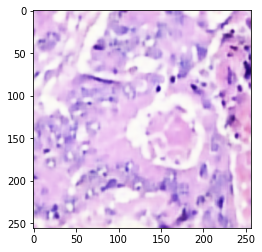

In [19]:
plt.imshow(pred[100].reshape(256,256,3))

In [ ]:
plt.imshow(pred[1000].reshape(256,256,3))

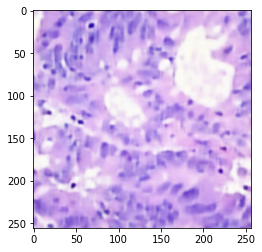

In [20]:
plt.imshow(pred[3000].reshape(256,256,3))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,067 (203.39 KB)

 Trainable params: 52,067 (203.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5549 - loss: 0.1143
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step - accuracy: 0.1992 - loss: 0.1059
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step - accuracy: 0.2371 - loss: 0.0914
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step - accuracy: 0.2625 - loss: 0.0696
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step - accuracy: 0.5377 - loss: 0.0442
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step - accuracy: 0.7972 - loss: 0.0266
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step - accuracy: 0.8451 - loss: 0.0306
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step - accuracy: 0.8508 - loss: 0.0373
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step - accuracy: 0.8509 - loss: 0.0376
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step - accuracy: 0.8515 - loss: 0.0346
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


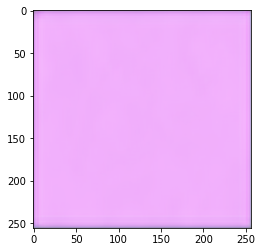

In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

np.random.seed(42)

img_size = 256
folder_path = 'C:/Users/Matias/Desktop/Tesis/prueba'

# Cargar todas las imágenes en la carpeta
img_data = []
for filename in os.listdir(folder_path):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):  # Asegúrate de procesar solo archivos de imagen
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, 1)
        if img is not None:
            rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            rgb_img = cv2.resize(rgb_img, (img_size, img_size))
            img_data.append(img_to_array(rgb_img))

# Preparar datos para el entrenamiento
img_final = np.reshape(img_data, (len(img_data), img_size, img_size, 3))
img_final = img_final.astype('float32') / 255

# Crear el modelo
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

# Compilar y entrenar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()
model.fit(img_final, img_final, epochs=10, shuffle=True)

# Predicción y visualización
pred = model.predict(img_final)
plt.imshow(pred[0].reshape(256,256,3))

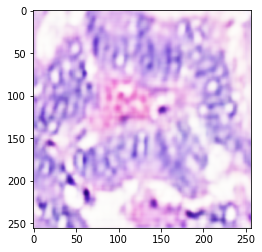

In [ ]:
plt.imshow(pred[1].reshape(256,256,3))

In [ ]:
pred[1].shape

(256, 256, 3)

In [ ]:


# Suponiendo que ya entrenaste cada autoencoder con imágenes correspondientes
# Puedes cargar tu DataFrame como antes y usar la función `crear_dataframe`
df = crear_dataframe(dataset_dir, autoencoders, size_by_type)
df


,ruta,etiqueta,tipo


In [ ]:
def crear_generadores(df, target_size=(256, 256), batch_size=20):
    if df.empty:
        raise ValueError("El DataFrame proporcionado está vacío. No se pueden crear generadores.")

    datagen = ImageDataGenerator(rescale=1./255)
    train_df, test_val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['etiqueta'])
    val_df, test_df = train_test_split(test_val_df, test_size=1/3, random_state=42, stratify=test_val_df['etiqueta'])

    train_generator = datagen.flow_from_dataframe(train_df, x_col='ruta', y_col='etiqueta', target_size=target_size, batch_size=batch_size, class_mode='binary', shuffle=True)
    validation_generator = datagen.flow_from_dataframe(val_df, x_col='ruta', y_col='etiqueta', target_size=target_size, batch_size=batch_size, class_mode='binary', shuffle=True)
    test_generator = datagen.flow_from_dataframe(test_df, x_col='ruta', y_col='etiqueta', target_size=target_size, batch_size=batch_size, class_mode='binary', shuffle=True)
    return train_generator, validation_generator, test_generator

#Usamos crear generadores
train_gen, val_gen, test_gen = crear_generadores(df)

ValueError: El DataFrame proporcionado está vacío. No se pueden crear generadores.

In [ ]:
# Llamada a la función
visualize_autoencoder_predictions(dataset_dir, autoencoders, size_by_type, num_samples=4)


## Modelos con Encoder Generales

In [ ]:
def entrenar_modelo_propio_encoder(train_gen, val_gen):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'FalsePositives', 'FalseNegatives'])

    history = model.fit(train_gen,
                        steps_per_epoch=100,  # Ajustar según el tamaño de tu conjunto de datos
                        epochs=10,
                        validation_data=val_gen,
                        validation_steps=50)  # Ajustar según el tamaño de tu conjunto de datos
    # Guardar el modelo
    model.save('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/modelo_encoder_general_propio.h5')

    # Guardar el historial de entrenamiento
    with open('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/encoder_general_propio_historial.pickle', 'wb') as f:
        pickle.dump(history.history, f)

    return model, history

# Ejecutar la función de entrenamiento
model, history = entrenar_modelo_propio_encoder(train_gen, val_gen)







c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - FalseNegatives: 111.2772 - FalsePositives: 165.5347 - accuracy: 0.7074 - loss: 0.5974 - val_FalseNegatives: 23.0000 - val_FalsePositives: 172.0000 - val_accuracy: 0.8050 - val_loss: 0.4682
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - FalseNegatives: 65.6337 - FalsePositives: 153.9901 - accuracy: 0.7802 - loss: 0.5149 - val_FalseNegatives: 1.0000 - val_FalsePositives: 274.0000 - val_accuracy: 0.7250 - val_loss: 0.6805
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - FalseNegatives: 65.0000 - FalsePositives: 146.7426 - accuracy: 0.7857 - loss: 0.4923 - val_FalseNegatives: 101.0000 - val_FalsePositives: 107.0000 - val_accuracy: 0.7920 - val_loss: 0.4710
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - FalseNegatives: 54.1287 - FalsePositives: 127.0396 - accuracy: 0.8123 - loss: 0.4485 - val_FalseNegatives: 82.0000 - val_FalsePositives: 105.0000 - val_accuracy: 0.8130 - val_loss: 0.4455
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - FalseNegatives: 124.4653 - FalsePositives: 291.9406 - accuracy: 0.5967 - loss: 0.7019 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 331.0000 - val_accuracy: 0.6690 - val_loss: 0.6320
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - FalseNegatives: 72.6040 - FalsePositives: 325.7327 - accuracy: 0.6134 - loss: 0.6868 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 343.0000 - val_accuracy: 0.6570 - val_loss: 0.6394
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - FalseNegatives: 25.0792 - FalsePositives: 332.6535 - accuracy: 0.6469 - loss: 0.6489 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 348.0000 - val_accuracy: 0.6520 - val_loss: 0.6420
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - FalseNegatives: 17.4158 - FalsePositives: 344.9010 - accuracy: 0.6546 - loss: 0.6491 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 374.0000 - val_accuracy: 0.6260 - val_loss: 0.6545
Epoch 5/10
100/

288/288 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step
Confusion matrix, without normalization


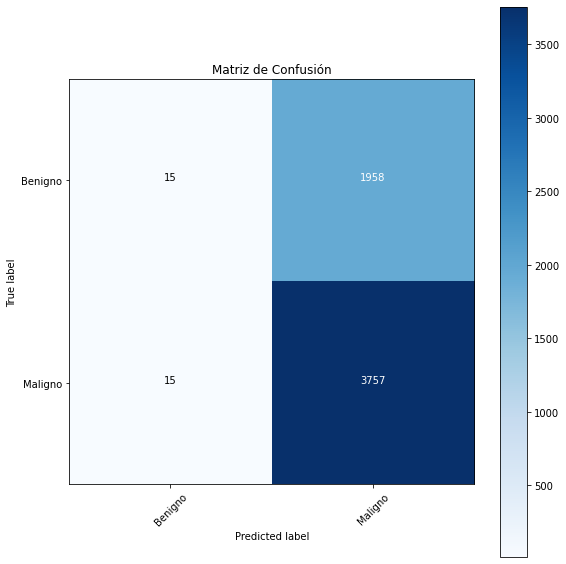

              precision    recall  f1-score   support

     Benigno       0.50      0.01      0.01      1973
     Maligno       0.66      1.00      0.79      3772

    accuracy                           0.66      5745
   macro avg       0.58      0.50      0.40      5745
weighted avg       0.60      0.66      0.53      5745



In [ ]:
def entrenar_modelo_ResNet50_encoder(train_gen, val_gen):
    # Cargar ResNet50 preentrenado como base, sin incluir las capas superiores
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # Construir la arquitectura del modelo añadiendo nuevas capas
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Reducción de dimensiones
    x = Dense(256, activation='relu')(x)  # Capa densa adicional similar a tu modelo
    x = Dropout(0.5)(x)  # Dropout para regularización
    predictions = Dense(1, activation='sigmoid')(x)  # Capa de salida para clasificación binaria

    # Formar el modelo completo especificando entradas y salidas
    model = Model(inputs=base_model.input, outputs=predictions)

    # Congelar las capas del modelo base para no ajustar sus pesos durante el entrenamiento
    for layer in base_model.layers:
        layer.trainable = False

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'FalsePositives', 'FalseNegatives'])

    # Entrenar el modelo
    history = model.fit(train_gen,
                        steps_per_epoch=100,  # Ajusta este valor según el tamaño de tu conjunto de datos
                        epochs=10,  # Número de épocas de entrenamiento
                        validation_data=val_gen,
                        validation_steps=50)  # Ajusta este valor según el tamaño de tu conjunto de validación

    return model, history

# Asegúrate de que 'train_gen' y 'val_gen' están correctamente inicializados
model, history = entrenar_modelo_ResNet50_encoder(train_gen, val_gen)

# Guardar el modelo
model.save('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/resnet50_encoder_modelo.h5')

# Guardar el historial de entrenamiento
with open('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/resnet50_encoder_historial.pickle', 'wb') as f:
    pickle.dump(history.history, f)

# Suponiendo que test_gen es tu generador de prueba
test_labels = test_gen.classes
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = (predictions > 0.5).astype(int).flatten()
# Calcular la matriz de confusión
cm = confusion_matrix(test_labels, predicted_classes)
class_names = ['Benigno', 'Maligno']  # Asumiendo que 0 = Benigno y 1 = Maligno

# Visualizar la matriz de confusión
plot_confusion_matrix(cm, classes=class_names, title='Matriz de Confusión')
# Mostrar el reporte de clasificación
print(classification_report(test_labels, predicted_classes, target_names=class_names))




In [ ]:
def entrenar_modelo_VGG16_encoder(train_gen, val_gen):
    # Cargar VGG16 preentrenado como base, sin incluir las capas superiores
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # Añadir nuevas capas personalizadas
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Agregar Dropout para ayudar a prevenir el sobreajuste
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Definir el modelo completo
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Congelar las capas del modelo base
    for layer in base_model.layers:
        layer.trainable = False

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'FalsePositives', 'FalseNegatives'])

    # Entrenar el modelo
    history = model.fit(train_gen,
                        epochs=10,
                        steps_per_epoch=100,  # Ajustar según el tamaño del conjunto de datos
                        validation_data=val_gen,
                        validation_steps=50)  # Ajustar según el tamaño del conjunto de validación

    # Guardar el modelo y el historial
    model.save('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/vgg16_encoder_modelo.h5')
    with open('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/vgg16_encoder_historial.pickle', 'wb') as f:
        pickle.dump(history.history, f)
    
    return model, history


# Asumiendo que 'train_gen' y 'val_gen' están correctamente configurados
model, history = entrenar_modelo_VGG16_encoder(train_gen, val_gen)
# Suponiendo que test_gen es tu generador de prueba
test_labels = test_gen.classes
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = (predictions > 0.5).astype(int).flatten()
# Mostrar el reporte de clasificación
print(classification_report(test_labels, predicted_classes, target_names=class_names))



Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - FalseNegatives: 83.7822 - FalsePositives: 207.5941 - accuracy: 0.6946 - loss: 0.5951 - val_FalseNegatives: 52.0000 - val_FalsePositives: 106.0000 - val_accuracy: 0.8420 - val_loss: 0.4220
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - FalseNegatives: 48.6535 - FalsePositives: 124.5842 - accuracy: 0.8307 - loss: 0.4111 - val_FalseNegatives: 59.0000 - val_FalsePositives: 81.0000 - val_accuracy: 0.8600 - val_loss: 0.3672
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 550s 6s/step - FalseNegatives: 48.6337 - FalsePositives: 107.6832 - accuracy: 0.8445 - loss: 0.3814 - val_FalseNegatives: 7.0000 - val_FalsePositives: 167.0000 - val_accuracy: 0.8260 - val_loss: 0.4534
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 757s 8s/step - FalseNegatives: 34.3564 - FalsePositives: 101.0891 - accuracy: 0.8673 - loss: 0.3418 - val_FalseNegatives: 25.0000 - val_FalsePositives: 122.0000 - val_accuracy: 0.8530 - val_loss: 0.3499
Epoch 5/10
100/100 ━━━━━━━━━━━

288/288 ━━━━━━━━━━━━━━━━━━━━ 798s 3s/step
              precision    recall  f1-score   support

     Benigno       0.34      0.24      0.28      1973
     Maligno       0.66      0.76      0.70      3772

    accuracy                           0.58      5745
   macro avg       0.50      0.50      0.49      5745
weighted avg       0.55      0.58      0.56      5745



## Modelos Multiclase Encoder

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd


def crear_generadores(df, target_size=(256, 256), batch_size=32, test_size=0.2, val_size=0.25):
    # Primero, dividimos los datos en conjuntos de entrenamiento+validación y prueba
    train_val_df, test_df = train_test_split(df, test_size=test_size, shuffle=True)
    # Luego, dividimos el conjunto de entrenamiento+validación en entrenamiento y validación
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, shuffle=True)  # val_size aquí es proporcional al tamaño de train_val_df

    datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=None,  # todas las rutas están completas en el DataFrame
        x_col='ruta',
        y_col='tipo',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=None,  # todas las rutas están completas en el DataFrame
        x_col='ruta',
        y_col='tipo',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    test_generator = datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=None,  # todas las rutas están completas en el DataFrame
        x_col='ruta',
        y_col='tipo',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Generalmente no mezclamos el conjunto de prueba para evaluar en el mismo orden
    )

    return train_generator, validation_generator, test_generator

# Suponiendo que df ya está cargado y listo
train_gen, val_gen, test_gen = crear_generadores(df)


Found 34499 validated image filenames belonging to 3 classes.


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 406 invalid image filename(s) in x_col="ruta". These filename(s) will be ignored.
  warnings.warn(


Found 11483 validated image filenames belonging to 3 classes.


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 152 invalid image filename(s) in x_col="ruta". These filename(s) will be ignored.
  warnings.warn(


Found 11498 validated image filenames belonging to 3 classes.


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 138 invalid image filename(s) in x_col="ruta". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def entrenar_modelo_propio_multiclase_encoder(train_gen, val_gen):
    # Aquí usamos 'class_indices' para obtener el número de clases
    num_classes = len(train_gen.class_indices)
    
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')  # Cambio para clasificación multiclase
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',  # Cambio a categorical_crossentropy
                  metrics=['accuracy'])
    
    history = model.fit(train_gen, 
                        validation_data=val_gen,
                        steps_per_epoch=100, 
                        epochs=10)  # Número de épocas ajustable
    #Guardamos el modelo
    model.save('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/modelo_general_propio_multiclase_encoder.h5')
    with open('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/general_models/historial_general_propio_multiclase_encoder.pickle', 'wb') as f:
        pickle.dump(history.history, f)

    return model, history

# Asumiendo que 'train_gen' y 'val_gen' están correctamente configurados
model, history = entrenar_modelo_propio_multiclase(train_gen, val_gen)
# Evaluar el modelo
test_labels = test_gen.classes
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = np.argmax(predictions, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(test_labels, predicted_classes)
class_names = list(val_gen.class_indices.keys())  # nombres de clases

# Función para graficar la matriz de confusión
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

# Reporte de clasificación
print(classification_report(test_labels, predicted_classes, target_names=class_names))

c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
 32/100 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - accuracy: 0.4532 - loss: 1.6445

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def entrenar_modelo_ResNet50_multiclase(train_gen, val_gen):
    num_classes = len(train_gen.class_indices)  

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)  # Cambio para clasificación multiclase

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',  # Cambio a categorical_crossentropy
                  metrics=['accuracy'])

    history = model.fit(train_gen,
                        steps_per_epoch=100,
                        epochs=10,
                        validation_data=val_gen,
                        validation_steps=50)
    # Guardar el modelo y el historial
    model.save('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/neoplasias_type_models/resnet50_multi_model_encoder.h5')
    with open('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/neoplasias_type_models/resnet50_multi_historial_encoder.pickle', 'wb') as f:
        pickle.dump(history.history, f)

    return model, history


# Asumiendo que 'train_gen' y 'val_gen' están correctamente configurados
model, history = entrenar_modelo_ResNet50_multiclase(train_gen, val_gen)
# Evaluar el modelo
test_labels = test_gen.classes
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = np.argmax(predictions, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(test_labels, predicted_classes)
class_names = list(val_gen.class_indices.keys())  # nombres de clases

# Función para graficar la matriz de confusión
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

# Reporte de clasificación
print(classification_report(test_labels, predicted_classes, target_names=class_names))

In [ ]:


def entrenar_modelo_VGG16_multiclase(train_gen, val_gen):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(len(train_gen.class_indices), activation='softmax')(x)  # Usar softmax para múltiples clases

    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',  # Cambiar a categorical_crossentropy
                  metrics=['accuracy'])

    history = model.fit(train_gen,
                        epochs=10,
                        steps_per_epoch=100,
                        validation_data=val_gen)
    
    # Guardar el modelo y el historial
    model.save('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/neoplasias_type_models/vgg16_multi_model_encoder.h5')
    with open('C:/Users/Matias/Desktop/Tesis/Tesis-Models/Encoder_models/neoplasias_type_models/vgg16_multi_historial_encoder.pickle', 'wb') as f:
        pickle.dump(history.history, f)

    return model, history

# Asumiendo que 'train_gen' y 'val_gen' están correctamente configurados
model, history = entrenar_modelo_VGG16_multiclase(train_gen, val_gen)
# Evaluar el modelo
test_labels = test_gen.classes
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = np.argmax(predictions, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(test_labels, predicted_classes)
class_names = list(val_gen.class_indices.keys())  # nombres de clases

# Función para graficar la matriz de confusión
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

# Reporte de clasificación
print(classification_report(test_labels, predicted_classes, target_names=class_names))

